In [1]:
def expand_input_feature_arr_to_n_history_steps_feature_arr(num_history_step,feature_arr):  
    """
    This fuction takes the feature_arr of size [num_trial_in-the-sess , 1] and builds feature_array of n_step_history for model input for a single session

    output:  numpyarray size:[total number of trials of the selected session + -num_history_step + 1   , 2*num_history_step]
    Input:   feature_arr - size [num_trial_in-the-sess , 1]
             can be any feature array, input_choiceRightLeft, input_choiceNull, input_reward_array. 
    """
    num_history_step
    
    arr_history = np.zeros((feature_arr.shape[0]-num_history_step, num_history_step))

    for i in range(arr_history.shape[0]):
        arr_history[i] = feature_arr[i:i+num_history_step].T

    return arr_history

In [2]:
def build_array_input_choice_Null_part(n, n_null, num_history_step, array_choice):
    """
    choice Null part
    second column:  Ignored : [1]
    otherwise : [0]
    """
    input_choice_Null_part = np.zeros((n,))
    input_choice_Null_part[array_choice == 1] = 1
    # input_choice_Null_part[-n_null:] = 1
    hist_array_input_choice_Null_part = expand_input_feature_arr_to_n_history_steps_feature_arr(num_history_step,input_choice_Null_part)

    return hist_array_input_choice_Null_part

In [3]:
def build_array_input_choice_RL_part(n, n_null, num_history_step, array_choice):
    
    """
    convert R0_nan1_L2 encoding TO R1_L-1_otherwise0 encoding
    'output_form' : 'R0_nan1_L2'
    
    choice RL part:
    right : [1]
    left : [-1]
    otherwise : [0]"""
    input_choice_LR_part = np.zeros((n,))
    for i in range(n - n_null):
            if array_choice[i] == 0: #if choice == right
                    input_choice_LR_part[i] = 1
            elif array_choice[i] == 2: #if choice == left
                    input_choice_LR_part[i] = -1
    hist_array_input_choice_LR_part = expand_input_feature_arr_to_n_history_steps_feature_arr(num_history_step,input_choice_LR_part)

    return hist_array_input_choice_LR_part

In [4]:
def build_array_input_rew_part(n, n_null, num_history_step, array_choice, array_rew_right, array_rew_left):
    """
    'output_form' : 'R0_nan1_L2'
    
    right rewarded           [1]  
    left rewarded            [-1]
    otherwise (no reward)    [0]
    """
    input_rew_part = np.zeros((n,))
    for i in range(n - n_null):
        if array_choice[i] == 0: #if choice == right
                if array_rew_right[i] ==1: # if right was rewarded
                        input_rew_part[i] = 1
        elif array_choice[i] == 2: #if choice == left
                if array_rew_left[i] == -1: # if left was rewarded
                        input_rew_part[i] = -1
    hist_array_rew = expand_input_feature_arr_to_n_history_steps_feature_arr(num_history_step,input_rew_part)

    return hist_array_rew

In [5]:
import numpy as np
from f_util_analyses import *
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# 'output_form' : 'R0_nan1_L2'

n=10000
n_null = 10
p=.8
num_history_step=4
num_iter_ = 100
p_rew = .2
array_rew_right = np.random.choice([1, 0], size=n , p=[p_rew, 1-p_rew])
array_rew_left = np.random.choice([-1, 0], size=n , p=[p_rew, 1-p_rew])
bias_array = np.ones((n - num_history_step,1))




# Generate "random" number with prob=p, and ecoding rule: 'output_form' : 'R0_nan1_L2'
array_choice = np.random.choice([0, 2], size=n - n_null, p=[p, 1-p])
array_choice = np.concatenate((array_choice, np.ones((n_null,))))
# hist_array = expand_input_feature_arr_to_n_history_steps_feature_arr(num_history_step,array)
output_rand = array_choice[num_history_step:].squeeze().astype(int).copy()  #'output_form' : 'R0_nan1_L2'

hist_array_rew = build_array_input_rew_part(n, n_null, num_history_step, array_choice, array_rew_right, array_rew_left) # RewRight:+1 , RewLeft:-1 , otherwise:0
hist_array_input_choice_LR_part = build_array_input_choice_RL_part(n, n_null, num_history_step, array_choice)  # R1_L-1_otherwise0 encoding
hist_array_input_choice_Null_part = build_array_input_choice_Null_part(n, n_null, num_history_step, array_choice) # Ignored : [1] , otherwise : [0]
                                        
input_rand = np.hstack((bias_array, hist_array_rew, hist_array_input_choice_LR_part, hist_array_input_choice_Null_part))






# Generate "bised to right" array, and ecoding rule: 'output_form' : 'R0_nan1_L2'
array_choice = np.zeros((n - n_null, )) # R0
array_choice = np.concatenate((array_choice, np.ones((n_null,))))
# hist_array = expand_input_feature_arr_to_n_history_steps_feature_arr(num_history_step,array)
output_rightBiased = array_choice[num_history_step:].squeeze().astype(int).copy()  # 'output_form' : 'R0_nan1_L2'

hist_array_rew = build_array_input_rew_part(n, n_null, num_history_step, array_choice, array_rew_right, array_rew_left) # RewRight:+1 , RewLeft:-1 , otherwise:0
hist_array_input_choice_LR_part = build_array_input_choice_RL_part(n, n_null, num_history_step, array_choice)  # R1_L-1_otherwise0 encoding
hist_array_input_choice_Null_part = build_array_input_choice_Null_part(n, n_null, num_history_step, array_choice) # Ignored : [1] , otherwise : [0]                                      

input_rightBiased = np.hstack((bias_array, hist_array_rew, hist_array_input_choice_LR_part, hist_array_input_choice_Null_part))





# Generate "alternating" pattern of right-left, and ecoding rule: 'output_form' : 'R0_nan1_L2'
array_choice = np.array([i % 2 for i in range(n - n_null)]) * 2 
array_choice = np.concatenate((array_choice, np.ones((n_null,))))
# hist_array = expand_input_feature_arr_to_n_history_steps_feature_arr(num_history_step,array)
output_alternating = array_choice[num_history_step:].squeeze().astype(int).copy() #'output_form' : 'R0_nan1_L2'

hist_array_rew = build_array_input_rew_part(n, n_null, num_history_step, array_choice, array_rew_right, array_rew_left) # RewRight:+1 , RewLeft:-1 , otherwise:0
hist_array_input_choice_LR_part = build_array_input_choice_RL_part(n, n_null, num_history_step, array_choice)  # R1_L-1_otherwise0 encoding
hist_array_input_choice_Null_part = build_array_input_choice_Null_part(n, n_null, num_history_step, array_choice) # Ignored : [1] , otherwise : [0]                                      

input_alternating = np.hstack((bias_array, hist_array_rew, hist_array_input_choice_LR_part, hist_array_input_choice_Null_part))





# Generate Win-Stay, and ecoding rule: 'output_form' : 'R0_nan1_L2', nothing implimented about Baiting
array_choice = np.zeros((n,))
""" 'output_form' : 'R0_nan1_L2' """
for i in range(n - n_null):
        if array_choice[i] == 0: # if choice == right
                if array_rew_right[i] == 1: # if right was rewarded
                        array_choice[i+1] = 0 # strategy = Win Stay
                else:
                        array_choice[i+1] = np.random.choice([0, 2], size=1, p=[.5,.5]) # strategy = Win Stay (nothing about Lose Switch)
        elif array_choice[i] == 2: # if choice == left
                if array_rew_left[i] == -1: # if left was rewarded
                        array_choice[i+1] = 2 # strategy = Win Stay
                else:
                        array_choice[i+1] = np.random.choice([0, 2], size=1, p=[.5,.5]) # strategy = Win Stay (nothing about Lose Switch)
array_choice[- n_null:] = 1

output_winStay = array_choice[num_history_step:].squeeze().astype(int).copy() #'output_form' : 'R0_nan1_L2'

hist_array_rew = build_array_input_rew_part(n, n_null, num_history_step, array_choice, array_rew_right, array_rew_left) # RewRight:+1 , RewLeft:-1 , otherwise:0
hist_array_input_choice_LR_part = build_array_input_choice_RL_part(n, n_null, num_history_step, array_choice)  # R1_L-1_otherwise0 encoding
hist_array_input_choice_Null_part = build_array_input_choice_Null_part(n, n_null, num_history_step, array_choice) # Ignored : [1] , otherwise : [0]                                      

input_winStay = np.hstack((bias_array, hist_array_rew, hist_array_input_choice_LR_part, hist_array_input_choice_Null_part))




# build_input_reward_  array_for_n_history_steps_all_sess_          Right1LeftMinus1Otherwise0_encoding
# build_input_choice_  array_for_n_history_steps_all_sess_           modifiedBari_encoding
# 'output_form' : 'R0_nan1_L2'
"""Bari encoding:
                choice: first colums:  right : [1]
                                        left : [-1]
                                        otherwise : [0]
                        second column:  Ignored : [1]
                                        otherwise : [0]
    output: size (num_trials_in_input_array, 2*num_hist_steps)
        """

"""
data[]['reward_history']: 2-d array, first dimension: left [0] / right [1], second dimension: trial number. 0 = no reward, 1 = rewarded

output: numpyarray size:[total number of trials for the selected sessionns , 1]
        reward_array will be a 1-dim array where
        column:     right rewarded           [1]  
                    left rewarded            [-1]
                    otherwise (no reward)    [0]
"""





# Generate Win-Stay_Lose_Switch, and ecoding rule: 'output_form' : 'R0_nan1_L2', nothing implimented about Baiting
#only ines woth ** are differenet from the WinStay algorithm
array_choice = np.zeros((n,))
""" 'output_form' : 'R0_nan1_L2' """
for i in range(n - n_null):
        if array_choice[i] == 0: # if choice == right
                if array_rew_right[i] == 1: # if right was rewarded
                        array_choice[i+1] = 0 # strategy = Win Stay
                else:
                        array_choice[i+1] = 2 # strategy =  Lose Switch **
        elif array_choice[i] == 2: # if choice == left
                if array_rew_left[i] == -1: # if left was rewarded
                        array_choice[i+1] = 2 # strategy = Win Stay
                else:
                        array_choice[i+1] = 0 # strategy = Lose Switch **
array_choice[- n_null:] = 1
output_winStayLoseSwitch = array_choice[num_history_step:].squeeze().astype(int).copy() #'output_form' : 'R0_nan1_L2' **

hist_array_rew = build_array_input_rew_part(n, n_null, num_history_step, array_choice, array_rew_right, array_rew_left) # RewRight:+1 , RewLeft:-1 , otherwise:0
hist_array_input_choice_LR_part = build_array_input_choice_RL_part(n, n_null, num_history_step, array_choice)  # R1_L-1_otherwise0 encoding
hist_array_input_choice_Null_part = build_array_input_choice_Null_part(n, n_null, num_history_step, array_choice) # Ignored : [1] , otherwise : [0]                                      

input_winStayLoseSwitch = np.hstack((bias_array, hist_array_rew, hist_array_input_choice_LR_part, hist_array_input_choice_Null_part))


In [6]:
"""
the python environment for the code: conda activate ssm_env_python3_9 
type_save= 'data-aspects' # can be ['data-aspects' , 'HMM-latent-satas']
"""

from f_util_preprocess import *
from f_util_plot import *
from f_util_analyses import *

hparams = {
    'data_dir': get_path_to_data_dir(),
    'save_dir': get_path_to_save_dir(),
    'mouse' : 'Synthetic_Mouse', # [FOR07, HH09, HH10]
    # 'experiment' : 'blockRew-coupled-baited',
    'data_type' : '.npy',
    'num_history_step' : 4,
    'num_hidden_states' : [1,2,3],
    'GLM' : 'multinomial', # can be ['bernoulli' , 'multinomial']
    'bias' : True,
    'bias_to_rich' : False,
    'water' : False,
    'obs_dim' : 1 ,          # number of observed dimensions
    'num_categories' : 3,   # number of categories for output
    'cols' : set_color_pallete(),
    'analysis_experiment_name' : 'modified_Bari', # choose from the list ['modified_Bari', 'bias_RewardOneHot_ChoiceOneHot', 'just_bias']     ['just_bias', 'bias_RewardOneHot', 'bias_ChoiceOneHot', \
    # 'bias_RewardOneHot_ChoiceOneHot', 'bias_RewardOneHot_Choice1FeatureNAN', 'bias_RewardBinary_ChoiceOneHot', 'bias_RewardWSLS_1FeatureChoiceNAN', 
    # 'bias_RewardOrdinal_Choice1Hot', 'bias_RewardWSLS_ChoiceOneHot']
    'num_iters' : 500,
    'tolerance' : 10**-5,
    'alphas' : [1, 2],
    'sigmas' : [0.5, 2], #[0.5, 0.75, 1, 2, 3, 4] #[0.5, 2] # [2, 3] 
    'output_form' : 'R0_nan1_L2',  # can be chosen from ['R0_L1_nan2', 'R0_nan1_L2']
    'observation_dim' : 1,
    'n_iters' : 500,
    'colors' : ['#ff7f00', '#4daf4a', '#377eb8', '#f781bf', '#999999', '#e41a1c', '#dede00', '#a65628', '#984ea3', '#97945a', '#c1cdc1',\
    '#00FFFF', '#FF00FF', '#FFA500', '#7FFFD4', '#00008B', '#00FF00', '#F7E7CE', '#EAC117', '#B275F7', '#9FDEBF'],
    'category_rew_prob' : [0.45,  0.4,   0.386, 0.338, 0.225, 0.113, 0.071, 0.064, 0.05 ],  
    'Sess_format': True
}


hparams['input_dim'] = n_input_dim(hparams)
hparams['alpha_sigma_sets'] = generate_hyperparameter_sets_for_mle_map(hparams['alphas'] , hparams['sigmas']) #"alpha_sigma_sets" used to be "hyperparameter_sets"

# data = import_data(hparams['data_dir'] + hparams['mouse'] + hparams['data_type']) # DataFrame of size 5*n_sessions, 
# To call data of, for example, choice_history of session 2, use this form: data[2]['choice_history'], which is a numpy.ndarray of size (1 , n_trilas)

    # ''' 
    # Export all foraging sessions (for Faeze)
    #
    # The dictionary in each .npy file uses session number as the key
    # {1: {'choice_history': 1-d array, 0 = left, 1 = right, nan = ignored
    #      'reward_history': 2-d array, first dimension: left [0] / right [1], second dimension: trial number. 0 = no reward, 1 = rewarded
    #      'p_reward': underlying reward refill probabilities. Same structure as reward_history
    #      'trial_num': total trial number (including ignored trials)
    #      'foraging_efficiency': overall performance of this session
    #      },
    #  2: data for session 2,
    #  ...
    # }
    # '''
# hparams['sessions'] = np.arange(1,np.shape(data)[1]+1)
# hparams['tot_n_sess'] = np.shape(data)[1]
# hparams['list_of_trial_count_in_chosen_sessens'] = get_list_of_trial_count_in_chosen_sessens(hparams, data)
# hparams['num_input_trials_segr_by_sessions'] = get_list_of_num_trials_for_chosen_sess_in_input_array(hparams)
# hparams['block_divider_trials'] = np.array(get_block_divider_in_selected_sess(hparams,data))
# hparams['sess_divider_trials'] = np.array(get_sess_divider_in_selected_sess(hparams))

hparams['input_labels'] = get_input_labels(hparams)
# hparams['num_trials_in_input_array'] = get_n_trials_for_input_array(hparams)
if hparams['GLM'] == 'multinomial':
    hparams['num_categories'] = 3
else:
    hparams['num_categories'] = 2



In [7]:
# """generate combined data from several strategies:
# output_rand, output_alternating, output_rightBiased, output_winStay, output_winStayLoseSwitch"""

# import random

# output1 = output_rand
# output2 = output_winStay

# input1 = input_rand
# input2 = input_winStay

# combined_output = np.empty(0, dtype=int)
# combined_input = np.empty((0, 3 * num_history_step + 1))
# label_combined = [] 

# a1 = 0
# a2 = 0

# max_part_length = 50
# num_split = np.ceil(3000/max_part_length).astype(int)

# for _ in range(num_split):
#     part_length1 = random.randint(1, max_part_length)
#     part_length2 = random.randint(1, max_part_length)
#     part1 = output1[a1 : a1+part_length1]
#     part2 = output2[a2 : a2+part_length2]
#     combined_output = np.concatenate((combined_output, part1, part2))
#     part1 = input1[a1 : a1+part_length1 , :]
#     part2 = input2[a2 : a2+part_length2, :]
#     combined_input = np.concatenate((combined_input, part1, part2))
#     a1 += part_length1
#     a2 += part_length2
#     label_combined.extend([0] * len(part1) + [1] * len(part2))



In [8]:
# """should be refined for right-biased --- to do later"""
# """generate combined data from several strategies:
# output_rand, output_alternating, output_rightBiased, output_winStay, output_winStayLoseSwitch"""

# import random

# output1 = output_rand
# output2 = output_winStay
# output3 = output_rightBiased
# output4 = output_alternating
# output5 = output_winStayLoseSwitch

# input1 = input_rand
# input2 = input_winStay
# input3 = input_rightBiased
# input4 = input_alternating
# input5 = input_winStayLoseSwitch

# combined_output = np.empty(0, dtype=int)
# combined_input = np.empty((0, 3 * num_history_step + 1))
# label_combined = [] 

# a1 = 0
# a2 = 0
# a3 = 0
# a4 = 0
# a5 = 0


# max_part_length = 100
# num_split = np.ceil(3000/max_part_length).astype(int)

# for _ in range(num_split):
#     part_length1 = random.randint(1, max_part_length)
#     part_length2 = random.randint(1, max_part_length)
#     part_length3 = random.randint(1, max_part_length)
#     part_length4 = random.randint(1, max_part_length)
#     part_length5 = random.randint(1, max_part_length)
#     part1 = output1[a1 : a1+part_length1]
#     part2 = output2[a2 : a2+part_length2]
#     part3 = output3[a3 : a3+part_length3]
#     part4 = output4[a4 : a4+part_length4]
#     part5 = output5[a5 : a5+part_length5]
#     parts = [part1, part2, part3, part4, part5]
#     # Create a permutation to apply the same order of shuffling to the second set
#     permutation = np.random.permutation(len(parts))
#     # Shuffle arrays in the second set using the same permutation
#     shuffled_parts = [parts[i] for i in permutation]
#     combined_output = np.concatenate((combined_output, shuffled_parts))

#     part1 = input1[a1 : a1+part_length1 , :]
#     part2 = input2[a2 : a2+part_length2, :]
#     part3 = input3[a3 : a3+part_length3 , :]
#     part4 = input4[a4 : a4+part_length4, :]
#     part5 = input5[a5 : a5+part_length5, :]
#     parts = [part1, part2, part3, part4, part5]
#     shuffled_parts = [parts[i] for i in permutation]
#     """generate combined data from several strategies:
# output_rand, output_alternating, output_rightBiased, output_winStay, output_winStayLoseSwitch"""

# import random

# output1 = output_rand
# output2 = output_winStay
# output3 = output_rightBiased
# output4 = output_alternating
# output5 = output_winStayLoseSwitch

# input1 = input_rand
# input2 = input_winStay
# input3 = input_rightBiased
# input4 = input_alternating
# input5 = input_winStayLoseSwitch

# combined_output = np.empty(0, dtype=int)
# combined_input = np.empty((0, 3 * num_history_step + 1))
# label_combined = [] 

# a1 = 0
# a2 = 0
# a3 = 0
# a4 = 0
# a5 = 0


# max_part_length = 100
# num_split = np.ceil(3000/max_part_length).astype(int)

# for _ in range(num_split):
#     part_length1 = random.randint(1, max_part_length)
#     part_length2 = random.randint(1, max_part_length)
#     part_length3 = random.randint(1, max_part_length)
#     part_length4 = random.randint(1, max_part_length)
#     part_length5 = random.randint(1, max_part_length)
#     part1 = output1[a1 : a1+part_length1]
#     part2 = output2[a2 : a2+part_length2]
#     part3 = output3[a3 : a3+part_length3]
#     part4 = output4[a4 : a4+part_length4]
#     part5 = output5[a5 : a5+part_length5]
#     parts = [part1, part2, part3, part4, part5]
#     # Create a permutation to apply the same order of shuffling to the second set
#     permutation = np.random.permutation(len(parts))
#     # Shuffle arrays in the second set using the same permutation
#     shuffled_parts = [parts[i] for i in permutation]
#     a =np.concatenate(shuffled_parts, axis=0)
#     combined_output = np.concatenate((combined_output, a), axis=0)

#     part1 = input1[a1 : a1+part_length1 , :]
#     part2 = input2[a2 : a2+part_length2, :]
#     part3 = input3[a3 : a3+part_length3 , :]
#     part4 = input4[a4 : a4+part_length4, :]
#     part5 = input5[a5 : a5+part_length5, :]
#     parts = [part1, part2, part3, part4, part5]
#     shuffled_parts = [parts[i] for i in permutation]
#     a =np.concatenate(shuffled_parts, axis=0)
#     combined_input = np.concatenate((combined_input, a), axis=0)

#     a1 += part_length1
#     a2 += part_length2
#     a3 += part_length3
#     a4 += part_length4
#     a5 += part_length5

#     label_combined = label_combined + [permutation[0]] * len(parts[permutation[0]]) + [permutation[1]] * len(parts[permutation[1]])+ [permutation[2]] * len(parts[permutation[2]])+\
#         [permutation[3]] * len(parts[permutation[3]])+ [permutation[4]] * len(parts[permutation[4]])




In [9]:
"""generate combined data from several strategies:
output_rand, output_alternating, output_rightBiased, output_winStay, output_winStayLoseSwitch"""

import random

output1 = output_rand
output2 = output_winStay
output3 = output_alternating
output4 = output_winStayLoseSwitch

input1 = input_rand
input2 = input_winStay
input3 = input_alternating
input4 = input_winStayLoseSwitch

combined_output = np.empty(0, dtype=int)
combined_input = np.empty((0, 3 * num_history_step + 1))
label_combined = [] 

a1 = 0
a2 = 0
a3 = 0
a4 = 0



max_part_length = 100
num_split = np.ceil(3000/max_part_length).astype(int)

for _ in range(num_split):
    part_length1 = random.randint(1, max_part_length)
    part_length2 = random.randint(1, max_part_length)
    part_length3 = random.randint(1, max_part_length)
    part_length4 = random.randint(1, max_part_length)
    part1 = output1[a1 : a1+part_length1]
    part2 = output2[a2 : a2+part_length2]
    part3 = output3[a3 : a3+part_length3]
    part4 = output4[a4 : a4+part_length4]
    parts = [part1, part2, part3, part4]
    # Create a permutation to apply the same order of shuffling to the second set
    permutation = np.random.permutation(len(parts))
    # Shuffle arrays in the second set using the same permutation
    shuffled_parts = [parts[i] for i in permutation]
    combined_output = np.concatenate((combined_output, shuffled_parts))

    part1 = input1[a1 : a1+part_length1 , :]
    part2 = input2[a2 : a2+part_length2, :]
    part3 = input3[a3 : a3+part_length3 , :]
    part4 = input4[a4 : a4+part_length4, :]
    parts = [part1, part2, part3, part4]
    shuffled_parts = [parts[i] for i in permutation]
    """generate combined data from several strategies:
output_rand, output_alternating, output_rightBiased, output_winStay, output_winStayLoseSwitch"""

import random

output1 = output_rand
output2 = output_winStay
output3 = output_alternating
output4 = output_winStayLoseSwitch

input1 = input_rand
input2 = input_winStay
input3 = input_alternating
input4 = input_winStayLoseSwitch

combined_output = np.empty(0, dtype=int)
combined_input = np.empty((0, 3 * num_history_step + 1))
label_combined = [] 

a1 = 0
a2 = 0
a3 = 0
a4 = 0


max_part_length = 100
num_split = np.ceil(3000/max_part_length).astype(int)

for _ in range(num_split):
    part_length1 = random.randint(1, max_part_length)
    part_length2 = random.randint(1, max_part_length)
    part_length3 = random.randint(1, max_part_length)
    part_length4 = random.randint(1, max_part_length)
    part1 = output1[a1 : a1+part_length1]
    part2 = output2[a2 : a2+part_length2]
    part3 = output3[a3 : a3+part_length3]
    part4 = output4[a4 : a4+part_length4]
    parts = [part1, part2, part3, part4]
    # Create a permutation to apply the same order of shuffling to the second set
    permutation = np.random.permutation(len(parts))
    # Shuffle arrays in the second set using the same permutation
    shuffled_parts = [parts[i] for i in permutation]
    a =np.concatenate(shuffled_parts, axis=0)
    combined_output = np.concatenate((combined_output, a), axis=0)

    part1 = input1[a1 : a1+part_length1 , :]
    part2 = input2[a2 : a2+part_length2, :]
    part3 = input3[a3 : a3+part_length3 , :]
    part4 = input4[a4 : a4+part_length4, :]
    parts = [part1, part2, part3, part4]
    shuffled_parts = [parts[i] for i in permutation]
    a =np.concatenate(shuffled_parts, axis=0)
    combined_input = np.concatenate((combined_input, a), axis=0)

    a1 += part_length1
    a2 += part_length2
    a3 += part_length3
    a4 += part_length4

    label_combined = label_combined + [permutation[0]] * len(parts[permutation[0]]) + [permutation[1]] * len(parts[permutation[1]])+ [permutation[2]] * len(parts[permutation[2]])+\
        [permutation[3]] * len(parts[permutation[3]])




<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
input_array = combined_input.copy()
output_array = combined_output.copy()


# input_array = input_winStayLoseSwitch.copy()
# output_array = output_winStayLoseSwitch.copy()

# iinput_array = input_winStay.copy()
# output_array = output_winStay.copy()

# input_array = input_rand.copy()
# output_array = output_rand.copy()

# input_arrayt = input_alternating.copy()
# output_array = output_alternating.copy()

# input_array = input_rightBiased.copy()
# output_array = output_rightBiased.copy()



In [11]:
input_design_matrix_list =[]
input_design_matrix_list.append(input_array.copy())


output_choice_list = []
output_choice_list.append(output_array.copy().reshape((-1,1)))

true_label_list = []
true_label_list.append(np.array(label_combined))

true_choices = output_choice_list
inpts = input_design_matrix_list


In [12]:
hparams['num_trials_in_input_array'] = len(output_choice_list[0])

/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


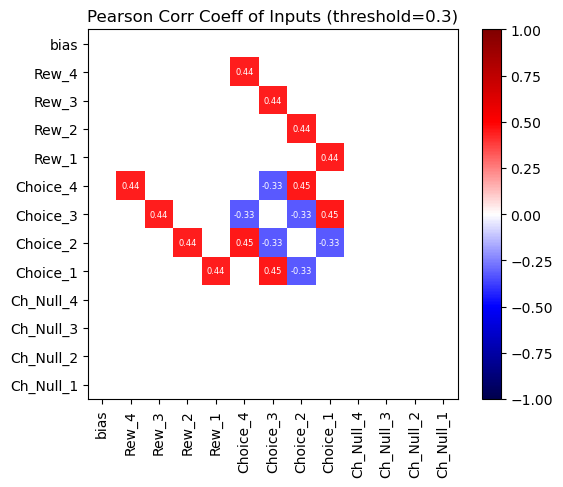

In [13]:
if np.shape(input_design_matrix_list)[2] > 1:
    plot_heatmap_of_pearson_corr_coeff_of_input_data(hparams, input_design_matrix_list, threshold = 0.3)
    plot_name = 'pearson_coeff' + '-' + hparams['mouse'] + '-' + hparams['analysis_experiment_name']
    # save_plot(hparams, type_save= 'data-aspects', plot_name = plot_name)

In [14]:
import ssm
obs_dim = hparams['observation_dim']        # number of observed dimensions
num_categories = hparams['num_categories']    # number of categories for output
input_dim = hparams['input_dim']         # input dimensions


num_states =  4   # number of discrete states

mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories), transitions="standard")

fit_ll = mle_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=hparams['n_iters'], tolerance=hparams['tolerance'])
mle_final_ll = mle_glmhmm.log_likelihood(true_choices, inputs=inpts) #/ hparams['num_trials_in_input_array']
print(mle_final_ll)

/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Converged to LP: -2727.6:   6%|▌         | 28/500 [00:01<00:33, 14.14it/s]


-1913.5822680119068


In [15]:
weights = mle_glmhmm.observations.params
log_transitions = mle_glmhmm.transitions.params

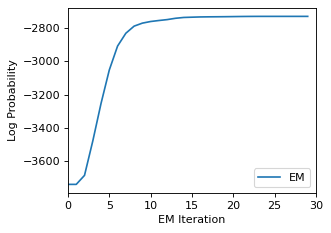

In [16]:
plot_log_prob_of_model_vs_EM_iteration_output_of_fit_fun_training_progress(fit_ll)

In [17]:
np.shape(true_label_list[0])

(6224,)

In [18]:
# permute recovered state identities to match state identities of generative model
from ssm.util import find_permutation
mle_glmhmm.permute(find_permutation(true_label_list[0], mle_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

# permute recovered state identities to match state identities of generative model
# new_glmhmm.permute(find_permutation(true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

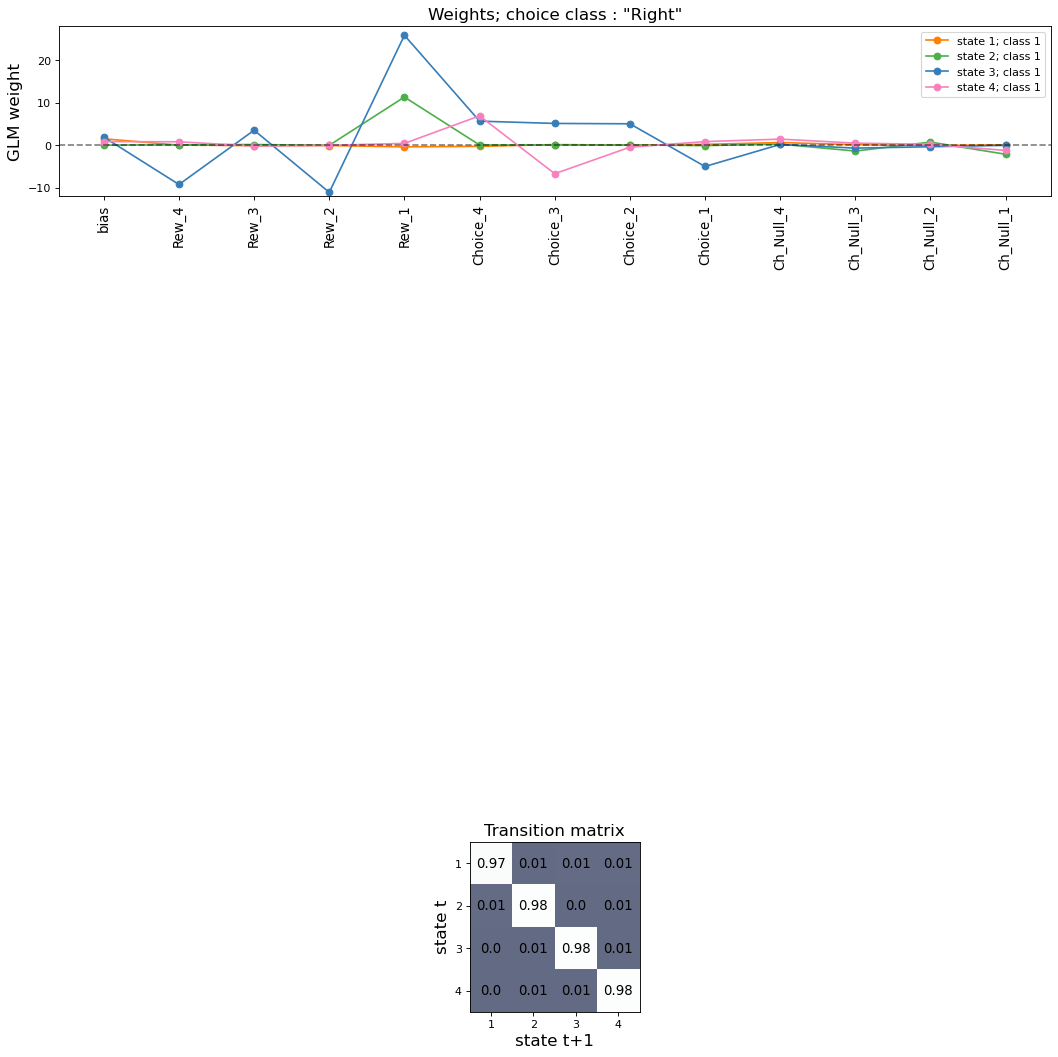

In [47]:
plot_weights_per_class_and_transition_matrix(hparams, weights, log_transitions, num_states)

[[84.88372093  3.10077519  6.66666667  5.34883721]
 [ 1.89718482 92.65605875  2.99877601  2.44798042]
 [ 0.          0.         99.29865576  0.70134424]
 [ 0.          0.69225928  2.07677785 97.23096287]]


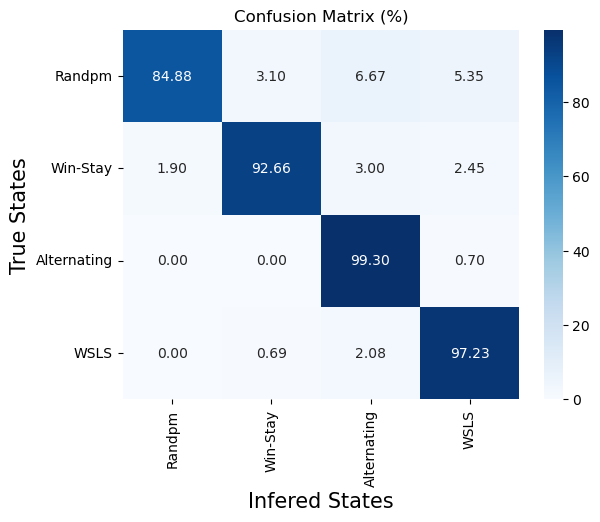

In [20]:
# Get expected states:
posterior_probs = [mle_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices, inpts)]


# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior_decor = np.argmax(posterior_probs_concat, axis = 1)

# # permute recovered state identities to match state identities of generative model
# state_max_posterior_decor = permute_array(np.array(true_latents_simul).squeeze(), state_max_posterior_decor)

# Count the number of occurrences of each pair of values
counts = np.bincount(num_states * np.array(true_label_list).squeeze() + state_max_posterior_decor, minlength=num_states**2).reshape(num_states, num_states)

# Calculate row sums for normalization
row_sums = counts.sum(axis=1, keepdims=True)

# Calculate the percentage matrix
percentage_matrix = (counts / row_sums) * 100

# Print the confusion matrix
print(percentage_matrix)

# Plot the confusion matrix as a heatmap
sns.heatmap(percentage_matrix, annot=True, cmap='Blues', fmt='.2f')

# Set the x-axis and y-axis tick labels
# tick_labels = [str(i+1) for i in range(num_states)]
# tick_labels = ['Randpm', 'Win-Stay', 'Right_Biased', 'Alternating', 'Win-Stay-Lose-Switch']
tick_labels = ['Randpm', 'Win-Stay', 'Alternating', 'WSLS']
plt.xticks(np.arange(num_states)+.5, tick_labels, rotation=90)
plt.yticks(np.arange(num_states)+.5, tick_labels, rotation=0)


# Set the axis labels
plt.xlabel('Infered States', fontsize=15)
plt.ylabel('True States', fontsize=15)

# Set the plot title
plt.title('Confusion Matrix (%)')

# Display the plot
plt.show()

Text(0, 0.5, 'p(state)')

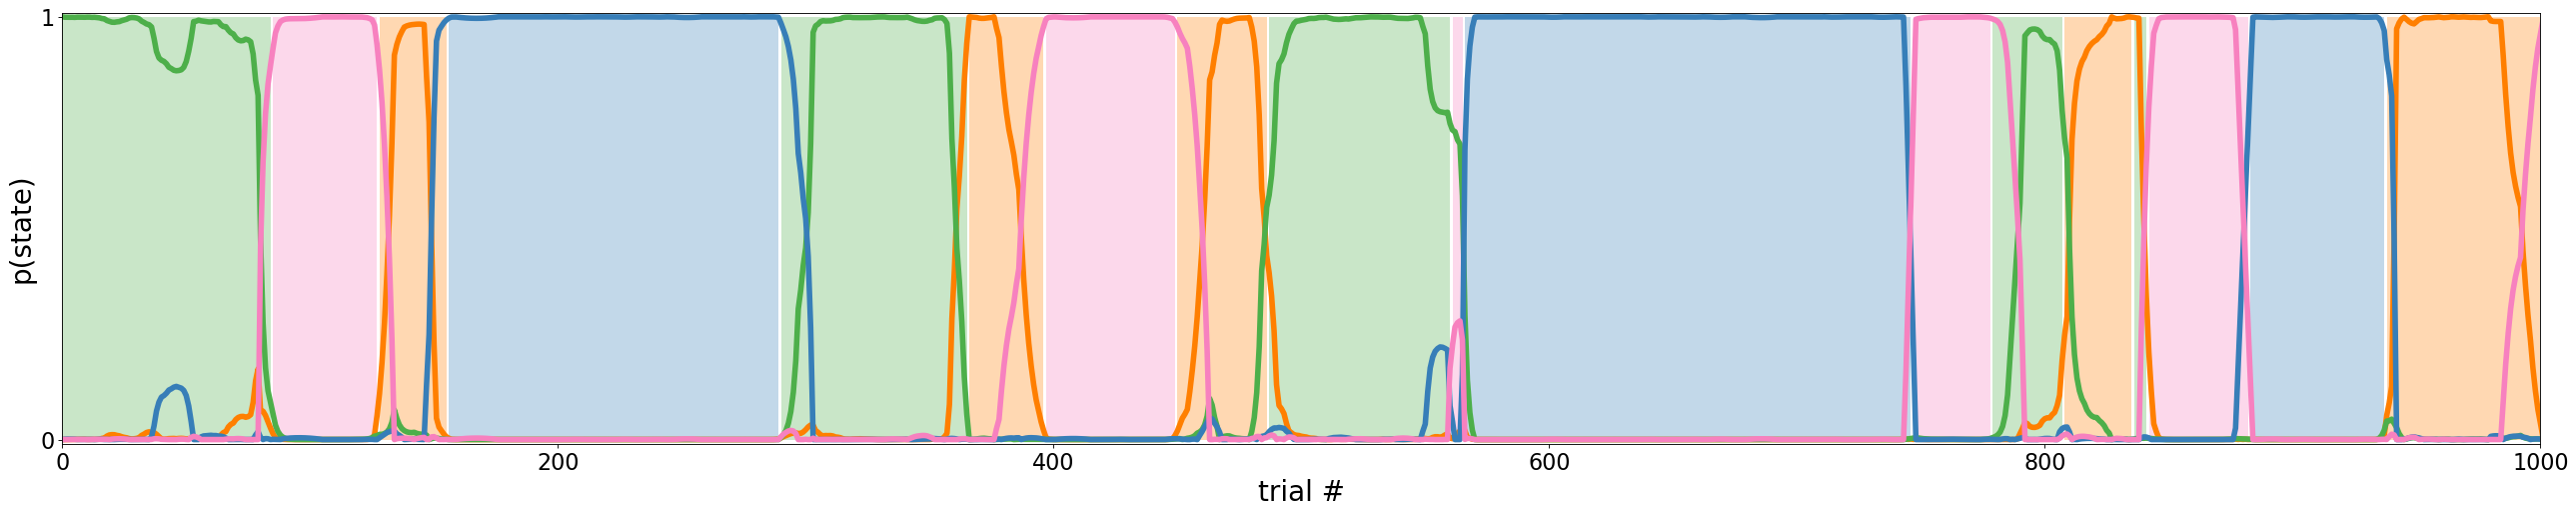

In [33]:
# fig = plt.figure(figsize=(40, 7), dpi=80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots(figsize=(40, 7), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; later in rowwise can be choosen any index between 0 and num_sess-1
start = 0
stop = -1

if stop == -1: 
    stop = hparams['num_trials_in_input_array']
for k in range(num_states):
    plt.plot(range(start,stop), posterior_probs[sess_id][start:stop, k], label="State " + str(k + 1), lw=5,
             color=hparams['colors'][k])

x = np.arange(hparams['num_trials_in_input_array'])  
# ax.fill_between(x, 0, 1, where=(true_label_list[0]==0), facecolor=hparams['colors'][0], alpha=0.3)
# ax.fill_between(x, 0, 1, where=(true_label_list[0] == 1), facecolor=hparams['colors'][1], alpha=0.3)
for i in range(num_states):
    ax.fill_between(x, 0, 1, where=(true_label_list[0]==i), facecolor=hparams['colors'][i], alpha=0.3)

# block_divider_trials = np.array(get_block_divider_in_selected_sess(hparams,data))
# plt.axvline(x=0, color='black', linestyle='--', label='session devider')
# idx = np.arange(np.searchsorted(hparams['block_divider_trials'], start),  np.searchsorted(hparams['block_divider_trials'], stop))
# idx = np.where((np.array(block_divider_trials) >= start) & (np.array(block_divider_trials) <=stop))[0]
# if len(idx) >0:
#     for num_trials in hparams['block_divider_trials'][idx]:
#         plt.axvline(x=num_trials, color='black', linestyle='--')

# sess_devider_trials = np.cumsum(np.array(hparams['num_input_trials_segr_by_sessions']))
# sess_divider_trials = np.array(get_sess_divider_in_selected_sess(hparams))
# idx = np.where((hparams['sess_divider_trials'] >= start) & (hparams['sess_divider_trials'] <=stop))[0]
# if len(idx) >0:
#     for num_trials in hparams['sess_divider_trials'][idx]:
#         plt.axvline(x=num_trials, color='black', linestyle='--', lw=5)

    
plt.ylim((-0.01, 1.01))
# plt.xlim((0, 1000))
plt.yticks([0, 1], fontsize = 20)
plt.xticks(fontsize = 20)
plt.xlabel("trial #", fontsize = 25)
plt.ylabel("p(state)", fontsize = 25)

Text(0, 0.5, 'Choice')

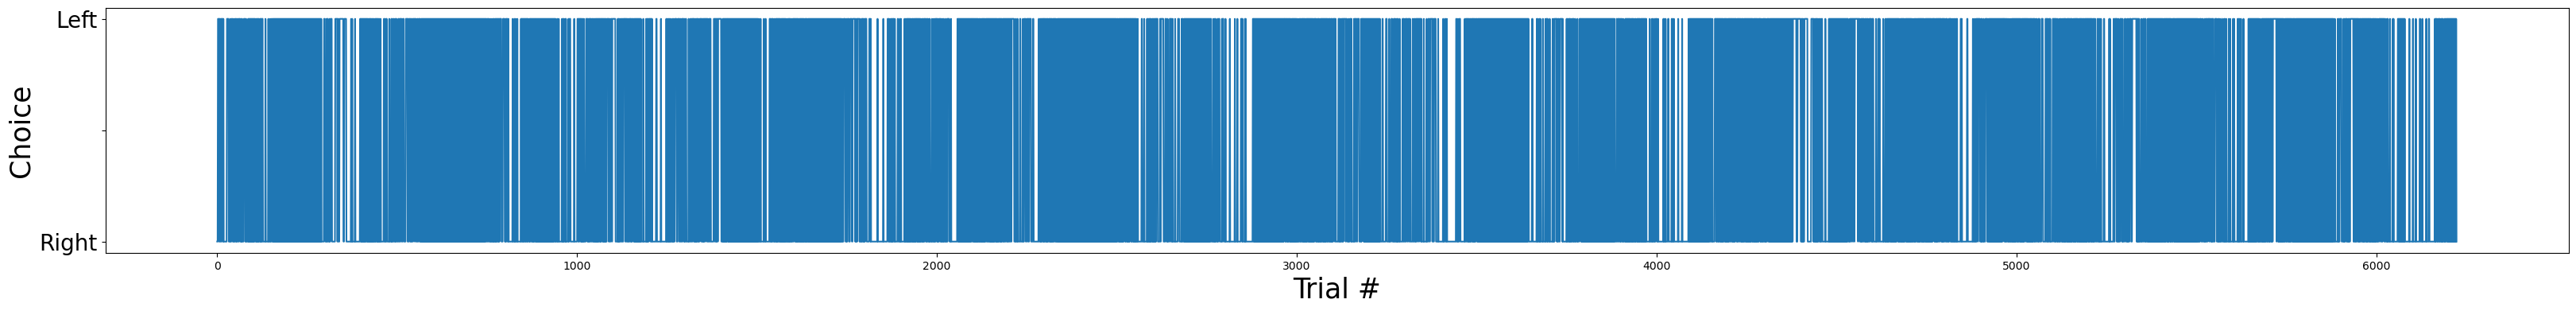

In [22]:
fig = plt.figure(figsize=(40,4))
plt.plot(range(start,stop), true_choices[0][start:stop])
plt.yticks([0, 1, 2], ['Right' , '', 'Left'], fontsize = 20)


plt.xlabel("Trial #", fontsize = 25)
plt.ylabel("Choice", fontsize = 25)
# # block_devider_trials = np.array(get_block_divider_in_selected_sess(hparams,data))
# # plt.axvline(x=0, color='black', linestyle='--', label='session devider')
# idx = np.where((np.array(hparams['block_divider_trials']) >= start) & (np.array(hparams['block_divider_trials']) <=stop))[0]
# if len(idx) >0:
#     for num_trials in hparams['block_divider_trials'][idx]:
#         plt.axvline(x=num_trials, color='black', linestyle='--')

# # sess_devider_trials = np.cumsum(np.array(hparams['num_input_trials_segr_by_sessions']))
# # sess_divider_trials = np.array(get_sess_divider_in_selected_sess(hparams))
# idx = np.where((hparams['sess_divider_trials'] >= start) & (hparams['sess_divider_trials'] <=stop))[0]
# if len(idx) >0:
#     for num_trials in hparams['sess_divider_trials'][idx]:
#         plt.axvline(x=num_trials, color='black', linestyle='--', lw=5)

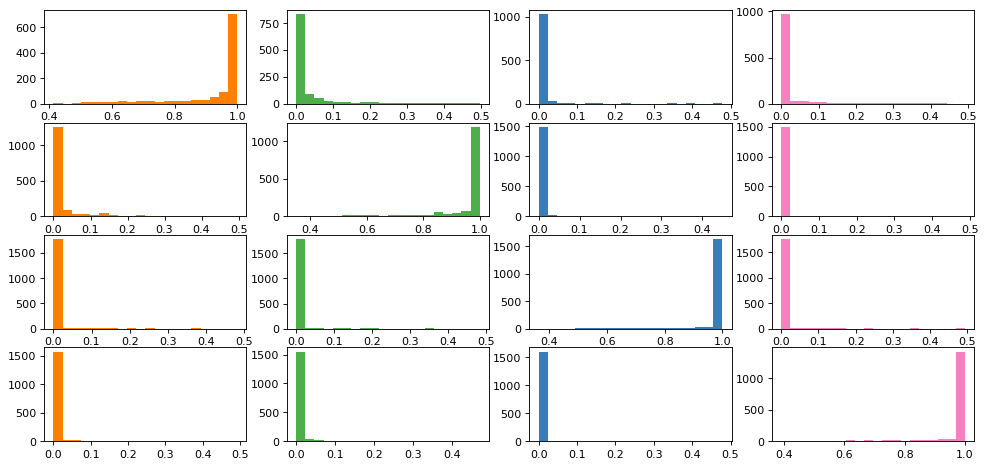

In [23]:
fig = plt.figure(figsize=(15, 7), dpi=80)

state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)

posterior_probs_concat_sess_train = np.reshape(np.array(posterior_probs) , (1,-1,num_states)).squeeze()   # (30000, 3)
for i in range(num_states):

    for j in range(num_states):
        plt.subplot(num_states,num_states,i*num_states+j+1)
        plt.hist(posterior_probs_concat_sess_train[state_max_posterior == i, j], bins = 20, color =hparams['colors'][j]) # density =True,

In [24]:
a = [[1,2],[3,4]]
np.linalg.eig(a)

(array([-0.37228132,  5.37228132]),
 array([[-0.82456484, -0.41597356],
        [ 0.56576746, -0.90937671]]))

In [25]:
np.linalg.eig(a - np.eye(2))

(array([-1.37228132,  4.37228132]),
 array([[-0.82456484, -0.41597356],
        [ 0.56576746, -0.90937671]]))

In [26]:
a - np.eye(2)

array([[0., 2.],
       [3., 3.]])